# Notebook to check if seeded median and on-demand median identify the same spikes consistently

In [2]:
import numpy as np
import zmq
import tifffile
import scipy
import random
import matplotlib.pyplot as plt

In [4]:
file_path = "/home/clewis/repos/holo-nbs/rb26_20240111/raw_voltage_chunk.tif"
data = tifffile.memmap(file_path)
data.shape

(384, 3000001)

In [5]:
# define filter functions
def butter(cutoff, fs, order=5, btype='high'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a


def butter_filter(data, cutoff, fs, order=5, axis=-1, btype='high'):
    b, a = butter(cutoff, fs, order=order, btype=btype)
    y = scipy.signal.filtfilt(b, a, data, axis=axis)
    return y

In [42]:
median = np.median(butter_filter(data[:, :4000], 1_000, 30_000), axis=1)
median.shape

(384,)

In [59]:
ixs = random.choices(range(4_000, data.shape[1]), k=5)
ixs

[943386, 1493939, 1619895, 2662138, 1506658]

In [60]:
ds = [butter_filter(data[:, i:i+150], 1_000, 30_000) for i in ixs]

In [61]:
len(ds)

5

In [13]:
ds[0].shape

(384, 150)

In [23]:
np.median(ds[0], axis=1)[0]

-0.2547269439471478

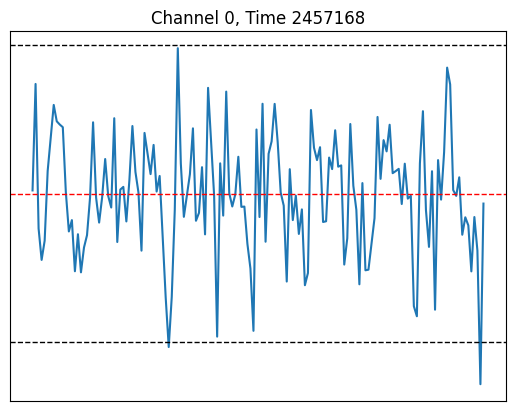

In [37]:
# Sample plot

plt.plot(ds[0][0, :])

# Add horizontal dashed lines at y = 10 and y = 50
plt.axhline(y=median[0], color='red', linestyle='--', linewidth=1)

#plt.axhline(y=np.median(ds[0], axis=1)[0], color='blue', linestyle='--', linewidth=1)

mad = scipy.stats.median_abs_deviation(ds[0], axis=1)

thresh = (4 * mad) 
plt.axhline(y=median[0] + thresh[0], color='black', linestyle='--', linewidth=1)
plt.axhline(y=median[0] - thresh[0], color='black', linestyle='--', linewidth=1)

plt.xticks([])  # removes x ticks
plt.yticks([])  # removes y ticks

plt.title(f"Channel 0, Time {ixs[0]}")
plt.show()

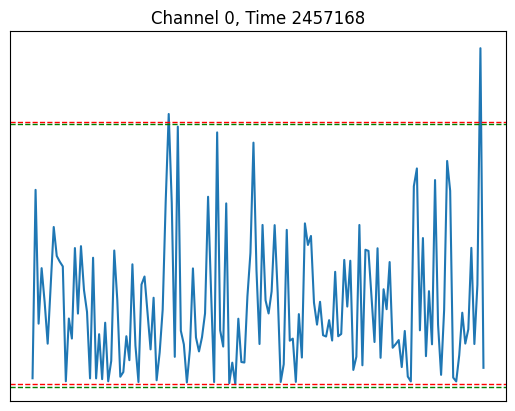

In [49]:
# Sample plot

plt.plot(np.abs(ds[0][0, :]))

# Add horizontal dashed lines at y = 10 and y = 50
plt.axhline(y=median[0], color='red', linestyle='--', linewidth=1)
plt.axhline(y=np.median(ds[0], axis=1)[0], color='green', linestyle='--', linewidth=1)

#plt.axhline(y=np.median(ds[0], axis=1)[0], color='blue', linestyle='--', linewidth=1)

mad = scipy.stats.median_abs_deviation(ds[0], axis=1)

thresh = (4 * mad) 
plt.axhline(y=median[0] + thresh[0], color='r', linestyle='--', linewidth=1)
plt.axhline(y=np.median(ds[0], axis=1)[0] + thresh[0], color='green', linestyle='--', linewidth=1)

# plt.axhline(y=median[0] - thresh[0], color='black', linestyle='--', linewidth=1)

plt.xticks([])  # removes x ticks
plt.yticks([])  # removes y ticks

plt.title(f"Channel 0, Time {ixs[0]}")
plt.show()

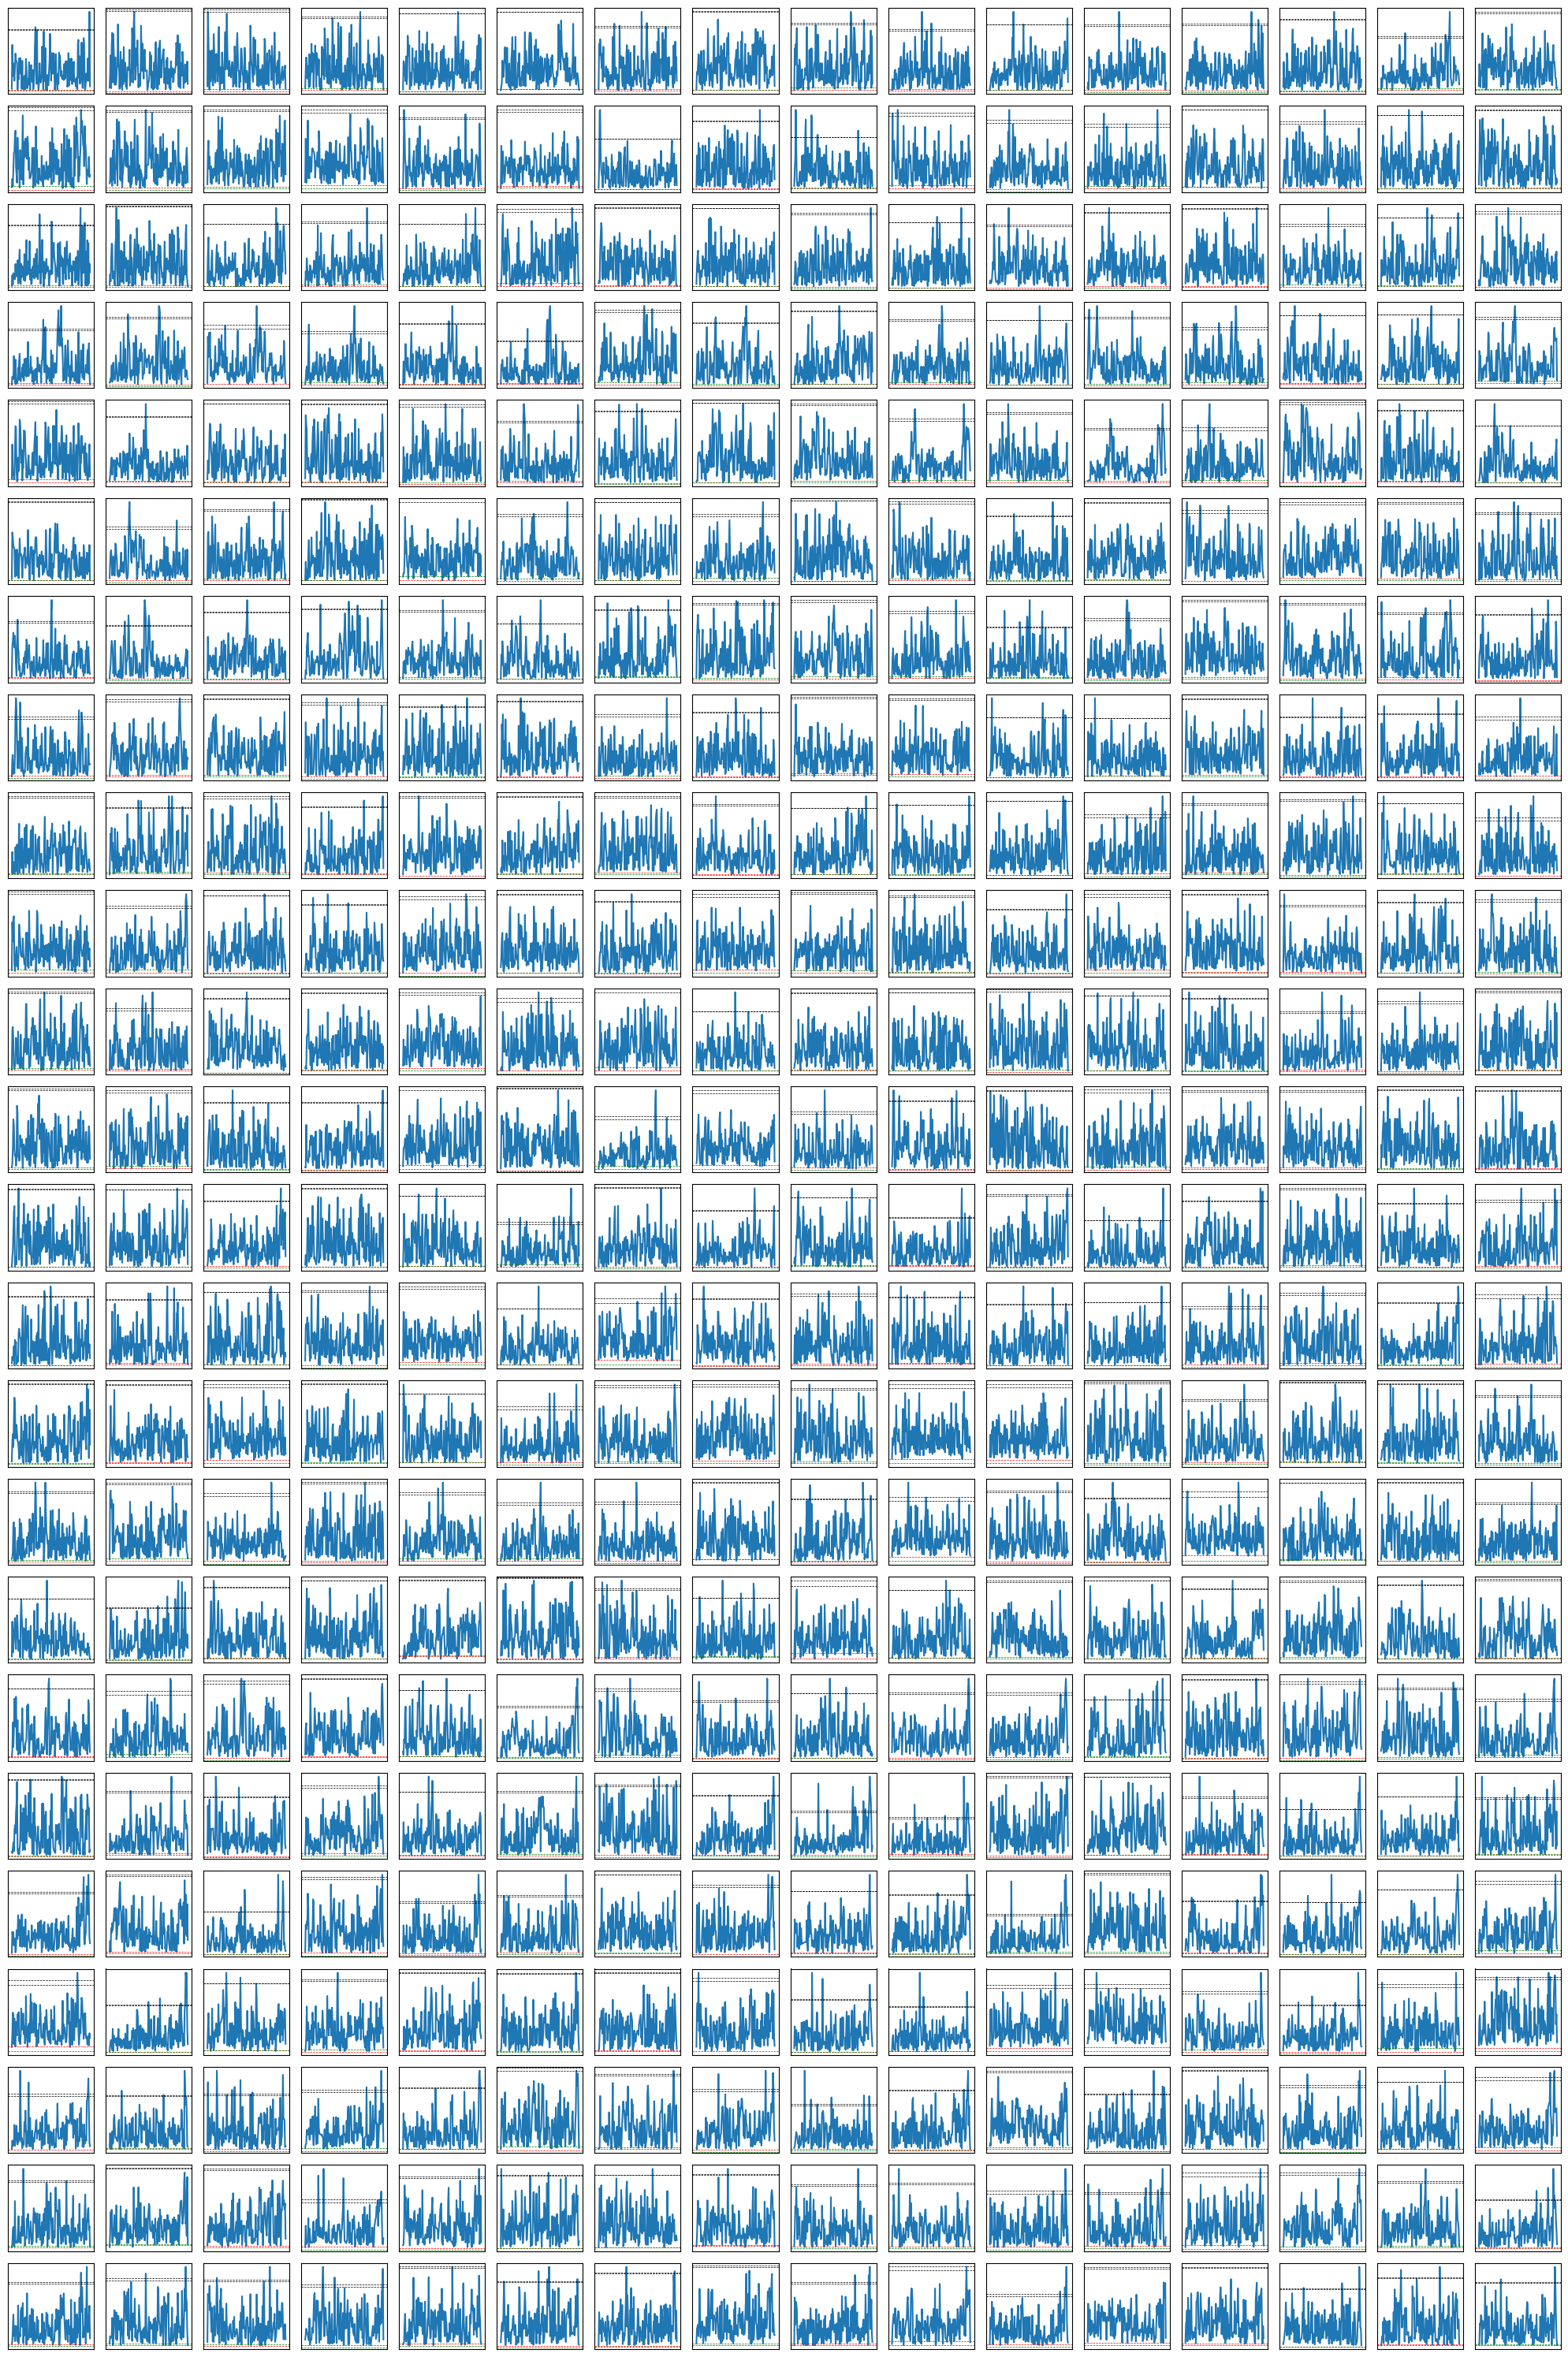

In [53]:
j = 0

# Number of subplots
n_subplots = 384
nrows, ncols = 24, 16

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 30))
axes = axes.flatten()  # flatten for easy iteration

mad = scipy.stats.median_abs_deviation(ds[j], axis=1)

nonseed_median = np.median(ds[j], axis=1)

thresh = (4 * mad) 

for i in range(n_subplots):
    axes[i].plot(np.abs(ds[j][i, :]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].axhline(y=median[i], color='r', linestyle='--', linewidth=0.5)
    axes[i].axhline(y=nonseed_median[i], color='green', linestyle='--', linewidth=0.5)
    axes[i].axhline(y=median[i] + thresh[i], color='black', linestyle='--', linewidth=0.5)
    axes[i].axhline(y=nonseed_median[i] + thresh[i], color='black', linestyle='--', linewidth=0.5)

    # axes[i].set_title(f"Plot {i+1}", fontsize=6)

plt.tight_layout()
plt.show()

In [54]:
def get_spike_events(data: np.ndarray):
    global median
    # calculate mad
    mad = scipy.stats.median_abs_deviation(data, axis=1)

    # Calculate threshold
    thresh = (4 * mad) + median

    # Vectorized computation of absolute data
    abs_data = np.abs(data)

    # Find indices where threshold is crossed for each channel
    spike_indices = [np.where(abs_data[i] > thresh[i])[0] for i in range(data.shape[0])]

    spike_counts = [np.count_nonzero(arr) for arr in spike_indices]

    return spike_indices, spike_counts

In [ ]:
# to find data points where this is happening; iterate through a bunch of time 
# get the spike counts for each channel and see at what times and what channels the spike count is greater than 100

In [70]:
for i in range(60_001, 65_000):
    d = butter_filter(data[:, i:i+150], 1_000, 30_000)
    spike_ixs, spike_counts = get_spike_events(d)
    if max(spike_counts) > 50:
        print(f"{i}: {max(spike_counts)}")
 
    #indices = [i for i, val in enumerate(spike_counts) if val > 50]

## Use the seeded median to calculate spikes

In [29]:
for j in range(5):
    lg = fig[j,0]["lg"]

    mad = scipy.stats.median_abs_deviation(ds[j], axis=1)

    thresh = (4 * mad) + median[:8]
    
    abs_data = np.abs(ds[j])
    
    # Find indices where threshold is crossed for each channel
    ixs = [np.where(abs_data[i] > thresh[i])[0] for i in range(ds[j].shape[0])]
    for i in range(len(ixs)):
        if ixs[i].shape[0] == 0:
            continue
        lg[i].colors[ixs[i]] = "orange"

## Use the median of the data to calculate spikes

In [30]:
for j in range(5):
    lg = fig[j,1]["lg"]

    mad = scipy.stats.median_abs_deviation(ds[j], axis=1)

    thresh = (4 * mad) + np.median(ds[j], axis=1)
    
    abs_data = np.abs(ds[j])
    
    # Find indices where threshold is crossed for each channel
    ixs = [np.where(abs_data[i] > thresh[i])[0] for i in range(ds[j].shape[0])]
    for i in range(len(ixs)):
        if ixs[i].shape[0] == 0:
            continue
        lg[i].colors[ixs[i]] = "orange"